# 브라질 이커머스 시장 분석 및 홈데코 카테고리 기점 성장 전략
Olist 공개 데이터(raw CSV) 기반으로 지표를 재계산하고, 시각화를 통해 근거를 제시합니다.


## 데이터 범위와 가정
- 데이터: Olist raw CSV (orders, order_items, reviews, products, customers, sellers)
- 분석 단위: 배송 완료 주문만 포함
- 배송일수: order_purchase_timestamp → order_delivered_customer_date (일 단위)
- 가격/배송비 비중: order_items.price 대비 order_items.freight_value


In [1]:
# 0) Setup
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 50)

sns.set_theme(style="whitegrid")
plt.rcParams["axes.unicode_minus"] = False


In [2]:
# 1) Load raw data
DATA_DIR = "c:/Users/user/projects/data/"

def load_csv(name):
    return pd.read_csv(os.path.join(DATA_DIR, name))

orders = load_csv("olist_orders_dataset.csv")
customers = load_csv("olist_customers_dataset.csv")
order_items = load_csv("olist_order_items_dataset.csv")
reviews = load_csv("olist_order_reviews_dataset.csv")
products = load_csv("olist_products_dataset.csv")
sellers = load_csv("olist_sellers_dataset.csv")

print("orders", orders.shape)
print("customers", customers.shape)
print("order_items", order_items.shape)
print("reviews", reviews.shape)
print("products", products.shape)
print("sellers", sellers.shape)


orders (99441, 8)
customers (99441, 5)
order_items (112650, 7)
reviews (99224, 7)
products (32951, 9)
sellers (3095, 4)


In [3]:
# 2) Basic cleaning + core joins
# Parse timestamps
for col in [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
]:
    orders[col] = pd.to_datetime(orders[col], errors="coerce")

orders_delivered = orders[orders["order_delivered_customer_date"].notna()].copy()
orders_delivered["delivery_days"] = (
    orders_delivered["order_delivered_customer_date"]
    - orders_delivered["order_purchase_timestamp"]
).dt.days

orders_delivered = orders_delivered[orders_delivered["delivery_days"] >= 0].copy()

orders_delivered = orders_delivered.merge(
    customers[["customer_id", "customer_unique_id", "customer_state"]],
    on="customer_id",
    how="left",
)

products["product_category_name"] = (
    products["product_category_name"].fillna("Unknown").astype(str).str.strip()
)
products.loc[products["product_category_name"] == "", "product_category_name"] = "Unknown"

items = order_items.merge(
    products[["product_id", "product_category_name"]],
    on="product_id",
    how="left",
)

items = items.merge(
    orders_delivered[["order_id", "delivery_days", "customer_unique_id"]],
    on="order_id",
    how="inner",
)

items = items[items["price"] > 0].copy()
items["freight_ratio"] = items["freight_value"] / items["price"]

reviews_base = reviews[["order_id", "review_score"]].dropna(subset=["review_score"]).copy()
order_reviews = orders_delivered[["order_id", "delivery_days"]].merge(
    reviews_base, on="order_id", how="inner"
)

items_reviews = items.merge(reviews_base, on="order_id", how="left")

print("orders_delivered", orders_delivered.shape)
print("items", items.shape)
print("order_reviews", order_reviews.shape)


orders_delivered (96476, 11)
items (110196, 11)
order_reviews (96359, 3)


## 1. 문제 정의 (Problem Definition)
브라질 이커머스의 첫 구매는 단순한 쇼핑이 아니라 **리스크를 감수하는 선택**이다. 배송 리드타임과 배송비의 불확실성이 첫 경험의 신뢰를 붕괴시키는 구조를 만든다.


- 유저의 첫 구매 불확실성
  - 누가 보내는가? (셀러 파손/사기 리스크)
  - 얼마를 더 내야 하는가? (과도한 배송비 부담)
  - 언제 도착하는가? (평균 배송 리드타임)


count    96476.000000
mean        12.094086
std          9.551746
min          0.000000
50%         10.000000
75%         15.000000
90%         23.000000
95%         29.000000
max        209.000000
Name: delivery_days, dtype: float64

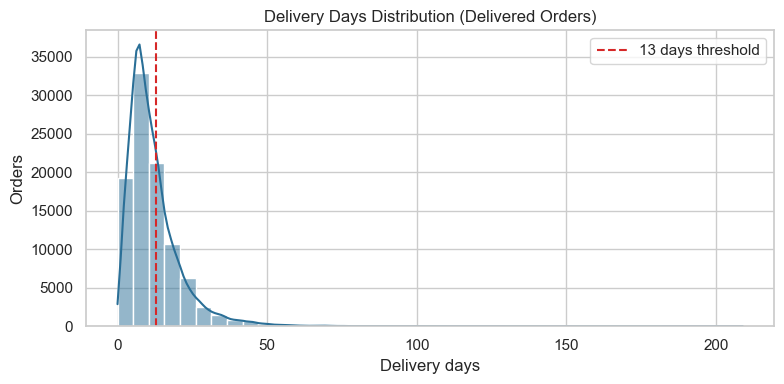

In [4]:
# 배송 리드타임 분포 (첫 경험 리스크)
delivery_stats = orders_delivered["delivery_days"].describe(percentiles=[0.5, 0.75, 0.9, 0.95])
display(delivery_stats)

plt.figure(figsize=(8, 4))
sns.histplot(orders_delivered["delivery_days"], bins=40, kde=True, color="#2a6f97")
plt.axvline(13, color="#d62828", linestyle="--", label="13 days threshold")
plt.title("Delivery Days Distribution (Delivered Orders)")
plt.xlabel("Delivery days")
plt.ylabel("Orders")
plt.legend()
plt.tight_layout()
plt.show()


,review_score,delivery_days
0,1,20.849825
1,2,16.194832
2,3,13.795278
3,4,11.848054
4,5,10.224097


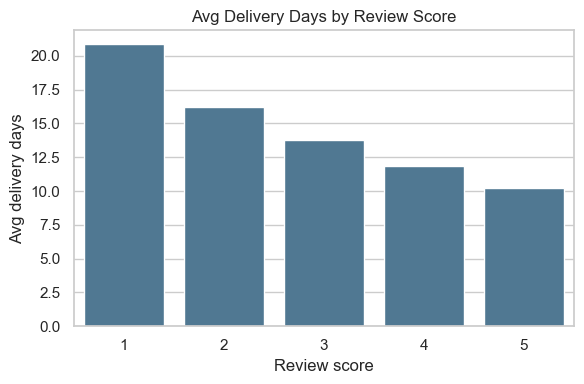

,late,low_review
0,False,0.083780
1,True,0.225865


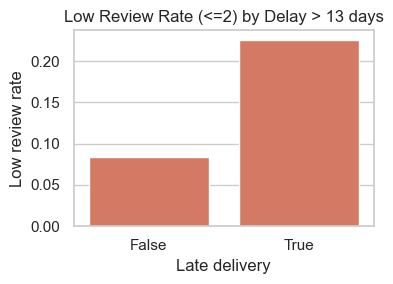

In [5]:
# 배송 지연과 리뷰 점수의 관계
delivery_by_score = (
    order_reviews.groupby("review_score")["delivery_days"].mean().reset_index()
)
display(delivery_by_score)

plt.figure(figsize=(6, 4))
sns.barplot(
    data=delivery_by_score,
    x="review_score",
    y="delivery_days",
    color="#457b9d",
)
plt.title("Avg Delivery Days by Review Score")
plt.xlabel("Review score")
plt.ylabel("Avg delivery days")
plt.tight_layout()
plt.show()

# 13일 초과 시 저평점 비중
threshold_days = 13
late_impact = order_reviews.assign(
    late=order_reviews["delivery_days"] > threshold_days,
    low_review=order_reviews["review_score"] <= 2,
)
late_summary = late_impact.groupby("late")["low_review"].mean().reset_index()
display(late_summary)

plt.figure(figsize=(4, 3))
sns.barplot(data=late_summary, x="late", y="low_review", color="#e76f51")
plt.title("Low Review Rate (<=2) by Delay > 13 days")
plt.xlabel("Late delivery")
plt.ylabel("Low review rate")
plt.tight_layout()
plt.show()


## 2. 브라질 이커머스의 구조적 한계
배송 리드타임의 불확실성과 배송비 비중, 지역 격차가 첫 구매 경험의 품질을 결정한다.


- 2.1 물류 리드타임의 심리적 마지노선
- 2.2 배송비의 벽 (Freight-to-Price Ratio)
- 2.3 지역적 양극화 (SP vs 기타 지역)


Overall freight ratio (weighted): 0.1663


,product_category_name,items_count,freight_ratio
31,eletronicos,2729,0.294621
58,moveis_sala,495,0.262720
11,bebidas,361,0.252732
56,moveis_escritorio,1668,0.250069
2,alimentos,499,0.245849
55,moveis_decoracao,8160,0.236544
73,utilidades_domesticas,6795,0.231899
71,telefonia,4430,0.223786
51,malas_acessorios,1077,0.216843
41,ferramentas_jardim,4268,0.205423


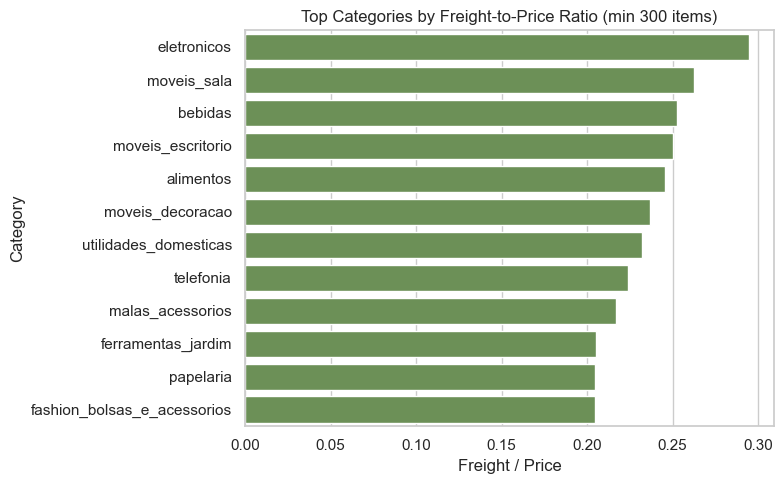

In [6]:
# 배송비 비중 (Freight-to-Price Ratio)
freight_overall = items["freight_value"].sum() / items["price"].sum()
print("Overall freight ratio (weighted):", round(freight_overall, 4))

category_freight = items.groupby("product_category_name").agg(
    items_count=("order_item_id", "count"),
    revenue=("price", "sum"),
    freight_total=("freight_value", "sum"),
).reset_index()
category_freight["freight_ratio"] = (
    category_freight["freight_total"] / category_freight["revenue"]
)

category_freight_filtered = category_freight[category_freight["items_count"] >= 300]
category_freight_top = category_freight_filtered.sort_values(
    "freight_ratio", ascending=False
).head(12)

display(category_freight_top[["product_category_name", "items_count", "freight_ratio"]])

plt.figure(figsize=(8, 5))
sns.barplot(
    data=category_freight_top,
    x="freight_ratio",
    y="product_category_name",
    color="#6a994e",
)
plt.title("Top Categories by Freight-to-Price Ratio (min 300 items)")
plt.xlabel("Freight / Price")
plt.ylabel("Category")
plt.tight_layout()
plt.show()


,region,delivery_days
0,Other,14.840017
1,SP,8.298061


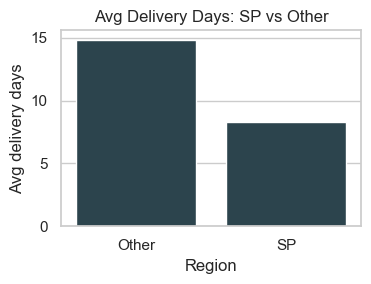

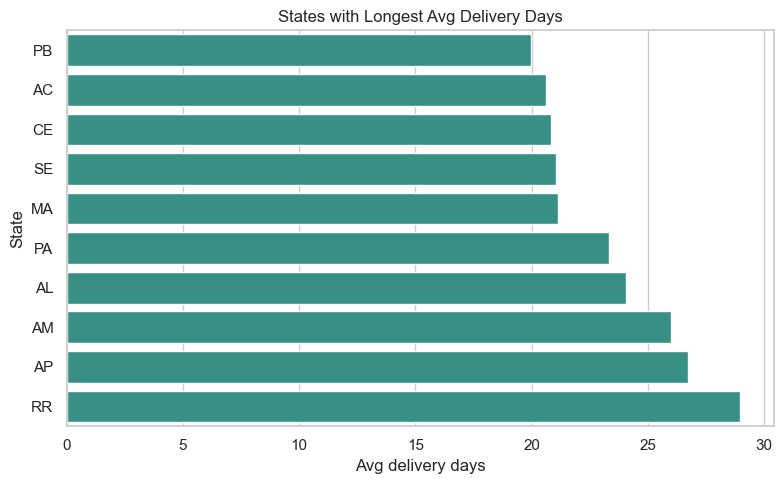

In [7]:
# 지역별 배송일 격차: SP vs Others
orders_delivered["region"] = np.where(
    orders_delivered["customer_state"] == "SP", "SP", "Other"
)
region_delivery = (
    orders_delivered.groupby("region")["delivery_days"].mean().reset_index()
)

state_delivery = (
    orders_delivered.groupby("customer_state")["delivery_days"].mean().reset_index()
    .sort_values("delivery_days")
)

display(region_delivery)

plt.figure(figsize=(4, 3))
sns.barplot(data=region_delivery, x="region", y="delivery_days", color="#264653")
plt.title("Avg Delivery Days: SP vs Other")
plt.xlabel("Region")
plt.ylabel("Avg delivery days")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(
    data=state_delivery.tail(10),
    x="delivery_days",
    y="customer_state",
    color="#2a9d8f",
)
plt.title("States with Longest Avg Delivery Days")
plt.xlabel("Avg delivery days")
plt.ylabel("State")
plt.tight_layout()
plt.show()


## 3. 왜 ‘홈데코’인가? (이커머스 적합도)
홈데코(침구/욕실)는 배송 지연에 대한 민감도가 낮고, 표준화가 높으며, 리뷰로 판단이 쉬운 카테고리다. 또한 동일 카테고리 내 재구매 가능성이 높아 첫 구매 성공 경험을 확장시키기 용이하다.


- 이커머스 적합도 체크리스트
  - 즉시성: 낮을수록 유리 (배송 지연 타격 감소)
  - 표준화: 높을수록 유리 (반품/설치 리스크 감소)
  - 리뷰 판단: 쉬울수록 유리 (정보 비대칭 완화)
  - 재구매 주기: 짧을수록 유리 (루프 형성)


In [8]:
# 카테고리별 핵심 지표 (배송, 리뷰, 배송비, 재구매)
category_summary = items_reviews.groupby("product_category_name").agg(
    items_count=("order_item_id", "count"),
    revenue=("price", "sum"),
    freight_total=("freight_value", "sum"),
    avg_delivery_days=("delivery_days", "mean"),
    avg_review_score=("review_score", "mean"),
).reset_index()
category_summary["freight_ratio"] = (
    category_summary["freight_total"] / category_summary["revenue"]
)

customer_cat_orders = (
    items.groupby(["customer_unique_id", "product_category_name"])["order_id"]
    .nunique()
    .reset_index(name="order_count")
)
repeat_rate = (
    customer_cat_orders.groupby("product_category_name")["order_count"]
    .apply(lambda s: (s >= 2).mean())
    .reset_index(name="repeat_rate")
)

category_summary = category_summary.merge(
    repeat_rate, on="product_category_name", how="left"
)

focus_categories = [
    "cama_mesa_banho",
    "moveis_decoracao",
    "eletronicos",
    "utilidades_domesticas",
]
focus_table = category_summary[
    category_summary["product_category_name"].isin(focus_categories)
].sort_values("revenue", ascending=False)

display(focus_table)


,product_category_name,items_count,revenue,freight_total,avg_delivery_days,avg_review_score,freight_ratio,repeat_rate
14,cama_mesa_banho,11107,1037177.69,204312.09,12.344017,3.920983,0.196989,0.027198
55,moveis_decoracao,8239,718344.78,170012.29,12.399078,3.950116,0.236672,0.020395
73,utilidades_domesticas,6819,617836.73,143218.70,10.458572,4.108407,0.231807,0.010562
31,eletronicos,2730,155173.83,45713.43,12.426374,4.067503,0.294595,0.003989


,category_group,items_count,revenue,avg_delivery_days,avg_review_score
0,furniture_large,10830,1124531.44,13.668790,3.887222
1,home_decor_soft,11107,1037177.69,12.344017,3.920983
2,other,88902,11117524.46,11.769207,4.124669


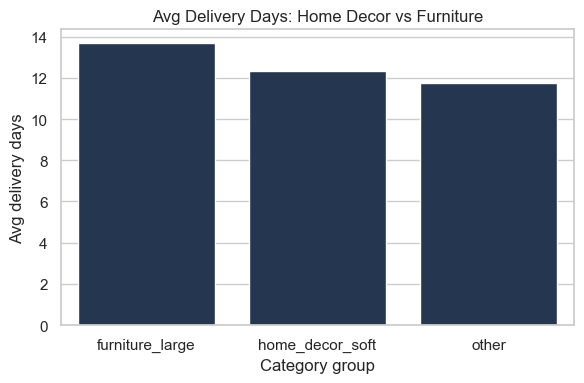

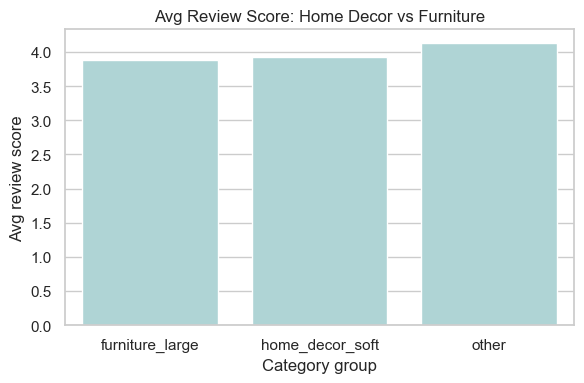

In [9]:
# 홈데코 vs 대형 가구(가구류 전체 그룹)
items_grouped = items_reviews.copy()
items_grouped["category_group"] = np.where(
    items_grouped["product_category_name"] == "cama_mesa_banho",
    "home_decor_soft",
    np.where(
        items_grouped["product_category_name"].str.startswith("moveis"),
        "furniture_large",
        "other",
    ),
)

group_summary = items_grouped.groupby("category_group").agg(
    items_count=("order_item_id", "count"),
    revenue=("price", "sum"),
    avg_delivery_days=("delivery_days", "mean"),
    avg_review_score=("review_score", "mean"),
).reset_index()

display(group_summary)

plt.figure(figsize=(6, 4))
sns.barplot(data=group_summary, x="category_group", y="avg_delivery_days", color="#1d3557")
plt.title("Avg Delivery Days: Home Decor vs Furniture")
plt.xlabel("Category group")
plt.ylabel("Avg delivery days")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.barplot(data=group_summary, x="category_group", y="avg_review_score", color="#a8dadc")
plt.title("Avg Review Score: Home Decor vs Furniture")
plt.xlabel("Category group")
plt.ylabel("Avg review score")
plt.tight_layout()
plt.show()


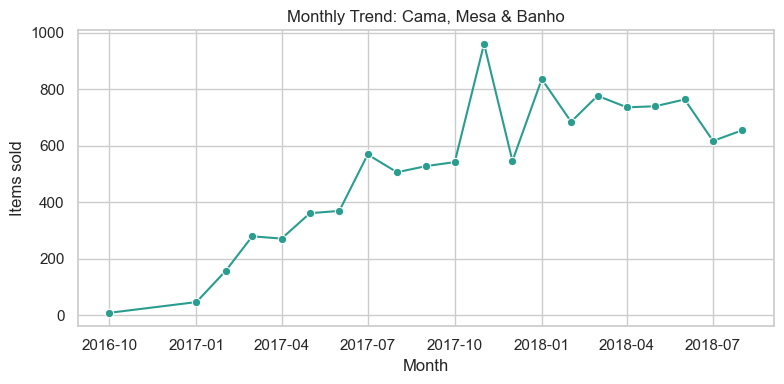

In [10]:
# 홈데코 월간 트렌드
orders_delivered["purchase_month"] = orders_delivered[
    "order_purchase_timestamp"
].dt.to_period("M").dt.to_timestamp()

items_home = items[items["product_category_name"] == "cama_mesa_banho"].merge(
    orders_delivered[["order_id", "purchase_month"]],
    on="order_id",
    how="left",
)

monthly_home = (
    items_home.groupby("purchase_month")["order_id"].count().reset_index(name="items")
)

plt.figure(figsize=(8, 4))
sns.lineplot(data=monthly_home, x="purchase_month", y="items", marker="o", color="#2a9d8f")
plt.title("Monthly Trend: Cama, Mesa & Banho")
plt.xlabel("Month")
plt.ylabel("Items sold")
plt.tight_layout()
plt.show()


## 4. 리텐션의 실체: 단계별 전환 확률
첫 구매 경험만 성공하면 이후 리텐션은 기하급수적으로 상승한다.


,step,probability
0,1->2,0.030003
1,2->3,0.081400
2,3->4,0.206140


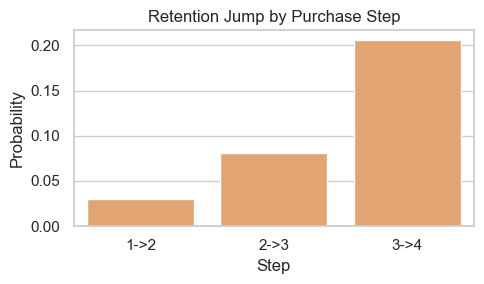

,region,is_repeat
0,Other,0.029662
1,SP,0.031418


In [11]:
# 리텐션 점프
orders_per_customer = orders_delivered.groupby("customer_unique_id")["order_id"].nunique()

p_1_to_2 = (orders_per_customer >= 2).mean()
p_2_to_3 = (orders_per_customer >= 3).sum() / (orders_per_customer >= 2).sum()
p_3_to_4 = (orders_per_customer >= 4).sum() / (orders_per_customer >= 3).sum()

retention_steps = pd.DataFrame(
    {
        "step": ["1->2", "2->3", "3->4"],
        "probability": [p_1_to_2, p_2_to_3, p_3_to_4],
    }
)

display(retention_steps)

plt.figure(figsize=(5, 3))
sns.barplot(data=retention_steps, x="step", y="probability", color="#f4a261")
plt.title("Retention Jump by Purchase Step")
plt.xlabel("Step")
plt.ylabel("Probability")
plt.tight_layout()
plt.show()

# SP vs Other retention
customer_state = orders_delivered[["customer_unique_id", "customer_state"]].drop_duplicates()
customer_orders = orders_per_customer.reset_index(name="order_count").merge(
    customer_state, on="customer_unique_id", how="left"
)
customer_orders["region"] = np.where(
    customer_orders["customer_state"] == "SP", "SP", "Other"
)
customer_orders["is_repeat"] = customer_orders["order_count"] >= 2
region_repeat = customer_orders.groupby("region")["is_repeat"].mean().reset_index()

display(region_repeat)


## 5. 핵심 전략 제안: Trust Bridge & Trust Transfer
신뢰가 형성되기 전 1회 구매에 모든 리소스를 집중한다.


- 전략 1: Super Seller Verified 입문관
  - 평점 4.5+, 빠른 배송 검증 셀러만 신규 유저에 노출
- 전략 2: First-Home Bundle
  - 침구+베개+수건 합배송 번들로 배송비 체감 최소화
- 전략 3: 친구 초대 기반 신뢰 전이
  - 본인 만족 상품 추천 시 양쪽에 배송비 크레딧
- 전략 4: 보상 방향 전환
  - 현금 할인보다 강한 “배송비 무료/크레딧” 중심


Top 5% seller revenue share: 0.5294


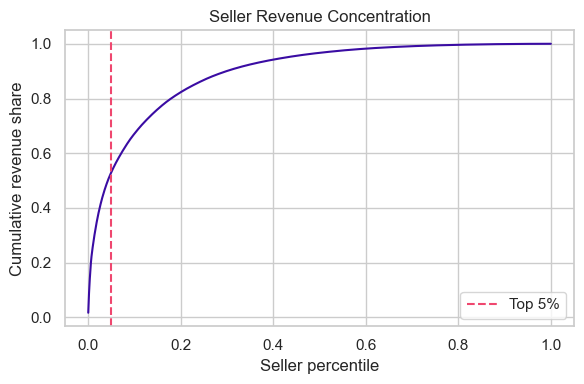

In [12]:
# 슈퍼 셀러 집중도 (상위 5% 매출 점유)
seller_revenue = (
    items.groupby("seller_id")["price"].sum().sort_values(ascending=False).reset_index()
)
seller_revenue["revenue_share"] = seller_revenue["price"] / seller_revenue["price"].sum()
seller_revenue["cum_share"] = seller_revenue["revenue_share"].cumsum()
seller_revenue["seller_rank"] = np.arange(1, len(seller_revenue) + 1)
seller_revenue["seller_pct"] = seller_revenue["seller_rank"] / len(seller_revenue)

top5_share = seller_revenue[seller_revenue["seller_pct"] <= 0.05]["revenue_share"].sum()
print("Top 5% seller revenue share:", round(top5_share, 4))

plt.figure(figsize=(6, 4))
sns.lineplot(data=seller_revenue, x="seller_pct", y="cum_share", color="#3a0ca3")
plt.title("Seller Revenue Concentration")
plt.xlabel("Seller percentile")
plt.ylabel("Cumulative revenue share")
plt.axvline(0.05, color="#ef476f", linestyle="--", label="Top 5%")
plt.legend()
plt.tight_layout()
plt.show()


## 6. 단계별 실행 로드맵 (Action Plan)
1) SP 하이퍼-로컬: 3일 확정 배송 라벨 + 추천코드
2) 슈퍼 셀러 락인: 상위 셀러 구독형 합배송 혜택
3) 소모품 크로스셀: 1차 구매 3개월 후 동일 셀러 소모품 추천


## 7. 한국 이커머스 비교 (선택 사항)
아래 섹션은 한국 시장의 외부 통계를 입력하면 자동 비교 시각화를 생성합니다. 정확한 보고서를 위해 공식 통계/리서치 값을 넣어주세요.


In [13]:
# 한국 벤치마크 (외부 통계 입력 필요)
# 예: 평균 배송일, 평균 배송비 비중, 재구매율 등
korea_benchmark = {
    "avg_delivery_days": np.nan,
    "freight_ratio_avg": np.nan,
    "repeat_rate": np.nan,
}

brazil_benchmark = {
    "avg_delivery_days": orders_delivered["delivery_days"].mean(),
    "freight_ratio_avg": items["freight_value"].sum() / items["price"].sum(),
    "repeat_rate": (orders_per_customer >= 2).mean(),
}

benchmark_df = pd.DataFrame([
    {"market": "Brazil (Olist)", **brazil_benchmark},
    {"market": "Korea (external)", **korea_benchmark},
])

display(benchmark_df)

if benchmark_df["avg_delivery_days"].isna().any():
    print("Korea benchmark values are NaN. Fill korea_benchmark to enable charts.")
else:
    plt.figure(figsize=(6, 4))
    sns.barplot(data=benchmark_df, x="market", y="avg_delivery_days", color="#118ab2")
    plt.title("Avg Delivery Days: Brazil vs Korea")
    plt.xlabel("Market")
    plt.ylabel("Avg delivery days")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    sns.barplot(data=benchmark_df, x="market", y="freight_ratio_avg", color="#06d6a0")
    plt.title("Freight-to-Price Ratio: Brazil vs Korea")
    plt.xlabel("Market")
    plt.ylabel("Freight / Price")
    plt.tight_layout()
    plt.show()


,market,avg_delivery_days,freight_ratio_avg,repeat_rate
0,Brazil (Olist),12.094086,0.166271,0.030003
1,Korea (external),NaN,NaN,NaN


Korea benchmark values are NaN. Fill korea_benchmark to enable charts.


In [14]:
# 핵심 수치 요약 (자동 생성)
from IPython.display import Markdown, display

def safe_value(series, default=np.nan):
    if len(series) == 0:
        return default
    return series.iloc[0]

avg_delivery = orders_delivered["delivery_days"].mean()
score_1 = safe_value(delivery_by_score.loc[delivery_by_score["review_score"] == 1, "delivery_days"])
score_5 = safe_value(delivery_by_score.loc[delivery_by_score["review_score"] == 5, "delivery_days"])
late_low = safe_value(late_summary.loc[late_summary["late"] == True, "low_review"])
on_time_low = safe_value(late_summary.loc[late_summary["late"] == False, "low_review"])
freight_weighted = items["freight_value"].sum() / items["price"].sum()
freight_elec = safe_value(
    category_freight.loc[category_freight["product_category_name"] == "eletronicos", "freight_ratio"]
)
sp_delivery = safe_value(region_delivery.loc[region_delivery["region"] == "SP", "delivery_days"])
other_delivery = safe_value(region_delivery.loc[region_delivery["region"] == "Other", "delivery_days"])
sp_repeat = safe_value(region_repeat.loc[region_repeat["region"] == "SP", "is_repeat"])
other_repeat = safe_value(region_repeat.loc[region_repeat["region"] == "Other", "is_repeat"])
home_repeat = safe_value(
    category_summary.loc[category_summary["product_category_name"] == "cama_mesa_banho", "repeat_rate"]
)
home_delivery = safe_value(group_summary.loc[group_summary["category_group"] == "home_decor_soft", "avg_delivery_days"])
furniture_delivery = safe_value(group_summary.loc[group_summary["category_group"] == "furniture_large", "avg_delivery_days"])

summary_md = f'''
### 핵심 수치 요약 (자동 계산)
- 평균 배송일: {avg_delivery:.1f}일
- 5점 vs 1점 평균 배송일: {score_5:.1f}일 vs {score_1:.1f}일
- 13일 초과 시 저평점 비중: {late_low:.1%} (<=13일: {on_time_low:.1%})
- 전체 배송비 비중(가중 평균): {freight_weighted:.1%}
- 전자제품 배송비 비중: {freight_elec:.1%}
- SP 배송일: {sp_delivery:.1f}일 / 기타: {other_delivery:.1f}일
- SP 재구매율: {sp_repeat:.1%} / 기타: {other_repeat:.1%}
- 리텐션: 1→2 {p_1_to_2:.2%}, 2→3 {p_2_to_3:.2%}, 3→4 {p_3_to_4:.2%}
- 홈데코(침구/욕실) 재구매율: {home_repeat:.1%}
- 가구류 평균 배송일: {furniture_delivery:.1f}일 (홈데코: {home_delivery:.1f}일)
- 상위 5% 셀러 매출 점유: {top5_share:.1%}
'''

display(Markdown(summary_md))



### 핵심 수치 요약 (자동 계산)
- 평균 배송일: 12.1일
- 5점 vs 1점 평균 배송일: 10.2일 vs 20.8일
- 13일 초과 시 저평점 비중: 22.6% (<=13일: 8.4%)
- 전체 배송비 비중(가중 평균): 16.6%
- 전자제품 배송비 비중: 29.5%
- SP 배송일: 8.3일 / 기타: 14.8일
- SP 재구매율: 3.1% / 기타: 3.0%
- 리텐션: 1→2 3.00%, 2→3 8.14%, 3→4 20.61%
- 홈데코(침구/욕실) 재구매율: 2.7%
- 가구류 평균 배송일: 13.7일 (홈데코: 12.3일)
- 상위 5% 셀러 매출 점유: 52.9%
